# Modèle disponible sur le site [https://www.tensorflow.org/tutorials/images/classification](https://www.tensorflow.org/tutorials/images/classification)
## Ceci est la mise en application du tutoriel, sur notre jeu de donnée d'image de pneumonie


### Import des librairies necessaires

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

### Préparation des paths vers le dossier d'entrainement et de validation des images

In [2]:
import pathlib

data_dir_train = pathlib.Path('chest_Xray/train')
data_dir_val = pathlib.Path('chest_Xray/val')

In [3]:
image_count = len(list(data_dir_train.glob('*/*.jpeg')))
print(image_count)

5216


### Paramètre du dataset

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Création des dataset

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_val,
    labels="inferred",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Impression d'un échantillon d'images

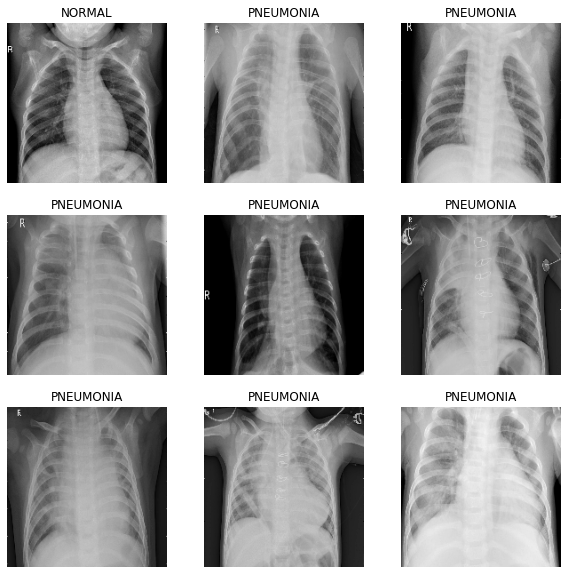

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.gray)
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Impression de la taille des données du dataset

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 1)
(32,)


### Mise en mémoire tampon des données pour optimiser les E/S vers le disque

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Définition, compilation et résumé du modele et de ses paramètres

In [10]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Entrainement du modèle

In [13]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 18s 19ms/step - loss: 0.2123 - accuracy: 0.9118 - val_loss: 1.0911 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0838 - accuracy: 0.9724 - val_loss: 0.8022 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0699 - accuracy: 0.9739 - val_loss: 0.1128 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0491 - accuracy: 0.9835 - val_loss: 0.0579 - val_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0396 - accuracy: 0.9852 - val_loss: 0.1752 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0318 - accuracy: 0.9872 - val_loss: 0.1117 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 3s 18ms/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.0194 - val_accuracy: 1.000

### Graphique des performances de l'entrainement

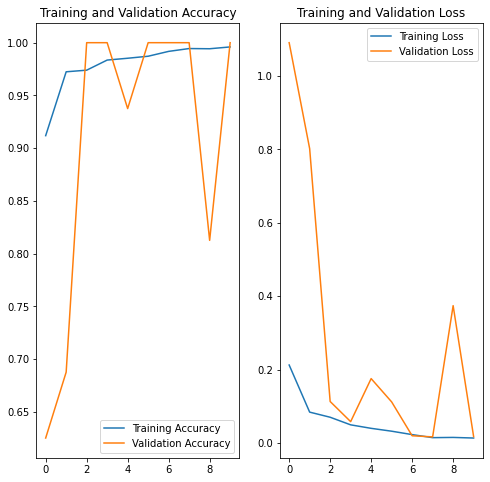

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Augmentation du jeu de données

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

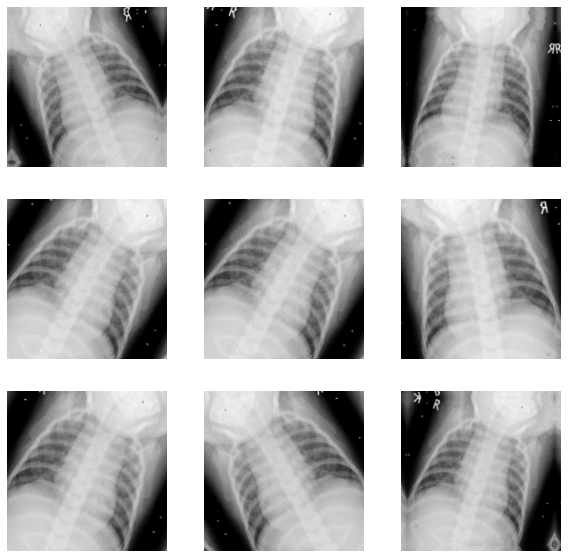

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap = plt.cm.gray)
        plt.axis("off")

### Définition et compilation du modèle

In [17]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Entrainement du modèle avec le dataset augmenté

In [20]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
163/163 [==============================] - 5s 22ms/step - loss: 0.4126 - accuracy: 0.8211 - val_loss: 1.1105 - val_accuracy: 0.6250
Epoch 2/15
163/163 [==============================] - 3s 21ms/step - loss: 0.2285 - accuracy: 0.9062 - val_loss: 0.5734 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1957 - accuracy: 0.9208 - val_loss: 0.5026 - val_accuracy: 0.8125
Epoch 4/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1623 - accuracy: 0.9358 - val_loss: 0.4385 - val_accuracy: 0.8750
Epoch 5/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1474 - accuracy: 0.9440 - val_loss: 0.4420 - val_accuracy: 0.8125
Epoch 6/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1407 - accuracy: 0.9454 - val_loss: 0.5068 - val_accuracy: 0.7500
Epoch 7/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1267 - accuracy: 0.9500 - val_loss: 0.4927 - val_accuracy: 0.8125

### Graphique représentant l'entrainement du dataset augmenté

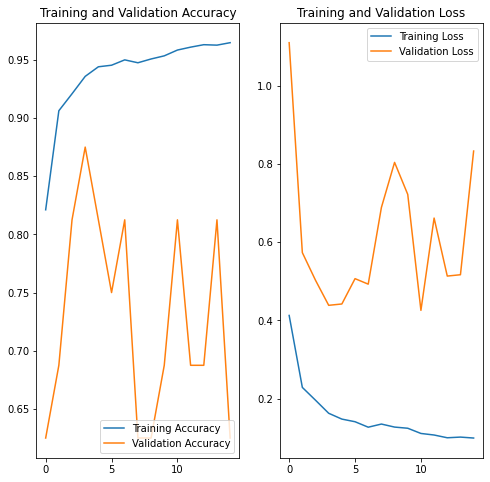

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Utilisation du modèle à fin de prédiction, et graphique des résultats de précisions obtenus

Found 624 files belonging to 2 classes.


<Figure size 432x288 with 0 Axes>

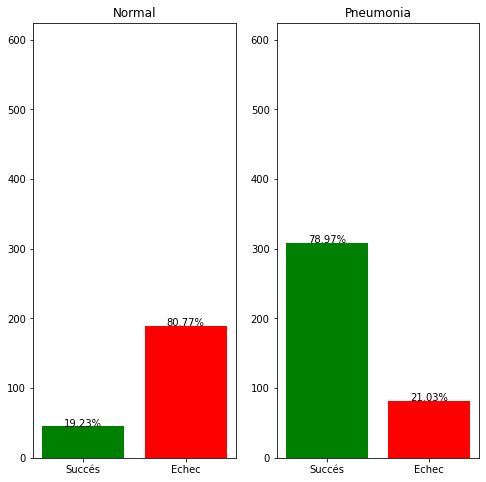

In [154]:
data_dir_test = pathlib.Path('chest_Xray/test')
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels="inferred",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

predictions = model.predict(test_ds)

labels = np.concatenate([y for x, y in test_ds], axis=0)
if len(predictions) == len(labels):
    output = [[0,0],[0,0]]
    for index, value in enumerate(predictions):
        if labels[index] == 0:
            if labels[index] == np.argmax(tf.nn.softmax(value)):
                output[0][0] += 1
            else:
                output[0][1] += 1
        else:
            if labels[index] == np.argmax(tf.nn.softmax(value)):
                output[1][0] += 1
            else:
                output[1][1] += 1

    X = np.arange(2)
    fig = plt.figure()
    plt.figure(figsize=(8, 8))
    plt.subplot(1,2,1)
    bars = plt.bar(X, output[0], color=['g', 'r'])
    for bar in bars:
        height = bar.get_height()
        val = round((height/(output[0][0]+output[0][1]))*100,2)
        plt.text(x=bar.get_x() + bar.get_width() / 2, y=height+.10,
        s="{}%".format(val),
        ha='center')
    plt.ylim(0, len(predictions))
    plt.xticks(X, ['Succés', 'Echec'], )
    plt.title('Normal')
    plt.subplot(1,2,2)
    bars = plt.bar(X, output[1], color=['g', 'r'])
    for bar in bars:
        height = bar.get_height()
        val = round((height/(output[1][0]+output[1][1]))*100,2)
        plt.text(x=bar.get_x() + bar.get_width() / 2, y=height+.10,
                 s="{}%".format(val),
                 ha='center')
    plt.ylim(0, len(predictions))
    plt.xticks(X, ['Succés', 'Echec'])
    plt.title('Pneumonia')
